# Exploratory Data Analytics for Santander Customer Transaction


## Importing libraries



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install shap
!pip install imbalanced-learn

     |████████████████████████████████| 276kB 2.7MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394122 sha256=d3e28008add8d9e8fec601410650fbcbe8487bc34da9561f8860b49e9b4f354c
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [12]:
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import missingno as msno
import numpy as np
import time
import gc

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, make_scorer, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import FeatureAgglomeration
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import imblearn
import shap
import IPython.display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from IPython.core.display import display, HTML, Javascript
from string import Template



## Loading and optimizing data

In [4]:
def reduce_mem_usage(df, verbose=True):
  """ iterate through all the columns of a dataframe and modify the data type
      to reduce memory usage.        
  """    
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  start_mem = df.memory_usage().sum() / 1024**2    
  print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))    
  
  for col in df.columns:
      col_type = df[col].dtypes
      if col_type in numerics:
          c_min = df[col].min()
          c_max = df[col].max()
          if str(col_type)[:3] == 'int':
              if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                  df[col] = df[col].astype(np.int8)
              elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                  df[col] = df[col].astype(np.int16)
              elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                  df[col] = df[col].astype(np.int32)
              elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                  df[col] = df[col].astype(np.int64)  
          else:
              if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                  df[col] = df[col].astype(np.float16)
              elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                  df[col] = df[col].astype(np.float32)
              else:
                  df[col] = df[col].astype(np.float64)
                  
  end_mem = df.memory_usage().sum() / 1024**2
  print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
  print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
  return df

In [5]:
df = pd.read_csv('drive/My Drive/Colab Notebooks/Santander Customer Transaction Prediction/data/train.csv')
df.drop(['ID_code'], axis=1, inplace=True)
df = reduce_mem_usage(df, verbose=True)

Memory usage of dataframe is 306.70 MB
Memory usage after optimization is: 76.48 MB
Decreased by 75.1%


In [7]:
df.shape

(200000, 202)

## Null, missing and duplicate values/ranges check

In [6]:
def check_missing_duplicate(dataset):

  print('Null/Missing values\n', dataset.isnull().sum())

  # making a bool series of duplicated items
  bool_series = dataset.duplicated(keep = False)
  print('Duplicated rows:', dataset[bool_series].shape[0])

  return None

In [9]:
check_missing_duplicate(df)

Null/Missing values
 ID_code    0
target     0
var_0      0
var_1      0
var_2      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 202, dtype: int64
Duplicated rows: 0


No missing values or no duplicates.

## EDA

Looking at the target variable.

Text(0, 0.5, 'Counts')

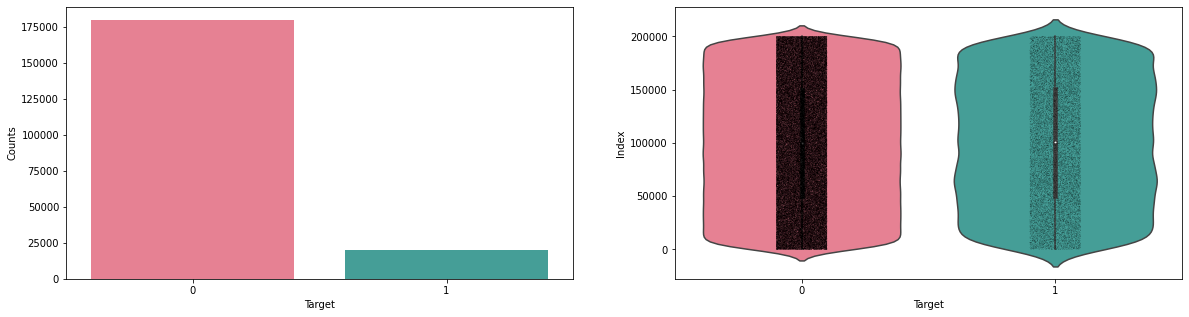

In [14]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.countplot(df.target.values, ax=ax[0], palette="husl")
sns.violinplot(x=df.target.values, y=df.index.values, ax=ax[1], palette="husl")
sns.stripplot(x=df.target.values, y=df.index.values,
              jitter=True, ax=ax[1], color="black", size=0.5, alpha=0.5)
ax[1].set_xlabel("Target")
ax[1].set_ylabel("Index")
ax[0].set_xlabel("Target")
ax[0].set_ylabel("Counts")

This shows a class imbalance problem - the likely transactions are much lower than non-transactions.  
Also, the target looks uniformly distributed across indexes.

Looking at feature correlation.

Text(0, 0.5, 'Density')

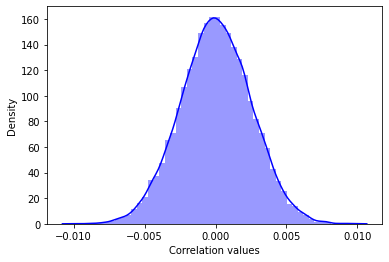

In [7]:
corr = df.drop(['target'], axis=1).corr()
corr = corr.values.flatten()
corr = corr[corr != 1] # Remove self correlation

plt.figure()
sns.distplot(corr, color="blue")
plt.xlabel("Correlation values")
plt.ylabel("Density")

There are no correlation at all in the variables.

Visualize variable ranges.

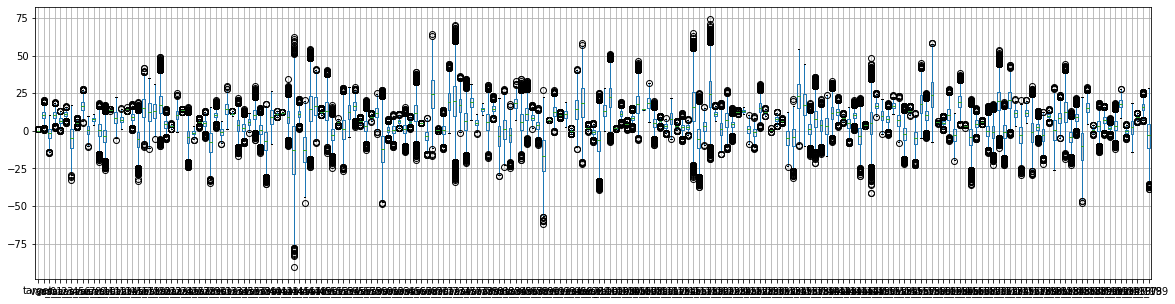

In [25]:
df.boxplot(figsize=(20, 5))

Variables have different distributions, therefore, normalizing should make sense in classification modeling.

## Data Sampling

In [16]:
df_x = df.drop(['target'], axis=1)
df_y = df[['target']]

X_train, X_val_test, Y_train, Y_val_test = train_test_split(df_x, df_y, shuffle=False, train_size=0.8)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, Y_val_test, shuffle=False, test_size=0.5)

In [22]:
X_train.shape, X_val.shape, X_test.shape

((160000, 200), (20000, 200), (20000, 200))

In [24]:
def evaluate(y_true, y_predicted):
  print("area under the ROC curve:", roc_auc_score(y_true, y_predicted))
  print(classification_report(y_true, y_predicted))
  print(confusion_matrix(y_true, y_predicted))

  auc = roc_auc_score(y_true, y_predicted)
  fpr, tpr, thresholds = roc_curve(y_true, y_predicted, pos_label=1)

  plt.plot(fpr, tpr)
  plt.plot([0, 1], [0, 1], '--')
  plt.xlim(0, 1.01)
  plt.ylim(0, 1.01)
  plt.title('AUC: {}'.format(round(auc, 2)))

## Preliminary feature importance analysis

In [7]:
params = {'n_estimators': [10]}
rfc = RandomForestClassifier(max_depth=15, min_samples_leaf=25)
rfc_grid = GridSearchCV(rfc, params, cv=3, n_jobs=-1, verbose=2, scoring=make_scorer(roc_auc_score))
rfc_grid.fit(X_train, Y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=15,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=25,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random

In [32]:
rfc_grid.best_score_

0.5000276792679595

In [34]:
rfc_grid.best_params_

{'n_estimators': 10}

In [22]:
def top_n_features(model, data, n=20):

  feature_importance = model.feature_importances_
  idx = np.argsort(feature_importance)[::-1][0:n]
  feature_names = data.columns.values

  plt.figure(figsize=(20,5))
  sns.barplot(x=feature_names[idx], y=feature_importance[idx])
  plt.title('Most important features.')

  return list(data.loc[:, feature_names[idx]].columns.values)

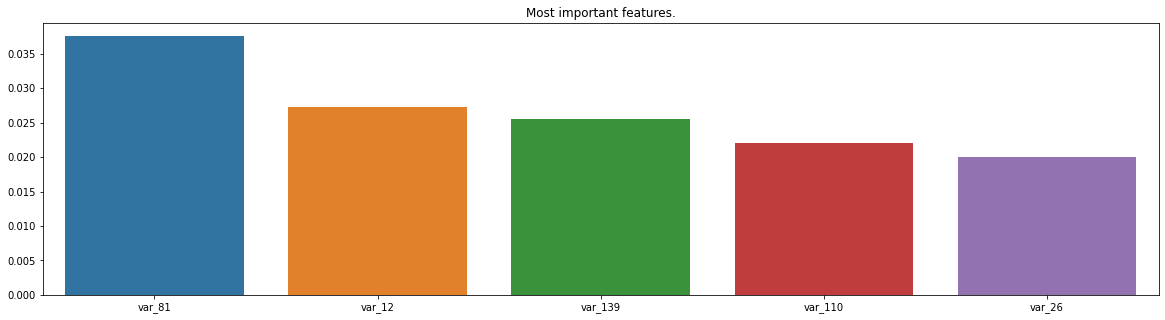

In [53]:
top_features = top_n_features(rfc_grid.best_estimator_, X_train, n=5)

In [ ]:
sns.pairplot(df[top_features + ['target']], hue="target")

## Feature Engineering 

1. Top n features
2. PCA
3. Variable clustering
4. Binning
5. Latent space generation (autoencoding) - Optional

### Modeling template

In [25]:
def train_model(model, x_train, y_train, x_val):

  model.fit(x_train, y_train)
  return model.predict_proba(x_val)

def eval_predictions(y_true, y_prob, threshold=0.1):
  y_pred = np.zeros(y_prob.shape[0])
  y_pred[y_prob[:,1] >= threshold] = 1
  evaluate(y_true, y_pred)

### Base Model

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



area under the ROC curve: 0.7711592331519938
              precision    recall  f1-score   support

           0       0.97      0.77      0.86     18009
           1       0.27      0.77      0.40      1991

    accuracy                           0.77     20000
   macro avg       0.62      0.77      0.63     20000
weighted avg       0.90      0.77      0.81     20000

[[13846  4163]
 [  451  1540]]


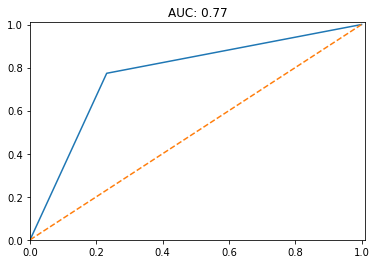

In [44]:
logisticRegr = LogisticRegression(solver = 'lbfgs')
y_prob = train_model(logisticRegr, X_train, Y_train, X_val)
eval_predictions(Y_val, y_prob, threshold=0.1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



area under the ROC curve: 0.7106868045970317
              precision    recall  f1-score   support

           0       0.96      0.64      0.77     18009
           1       0.19      0.78      0.31      1991

    accuracy                           0.65     20000
   macro avg       0.58      0.71      0.54     20000
weighted avg       0.89      0.65      0.72     20000

[[11487  6522]
 [  431  1560]]


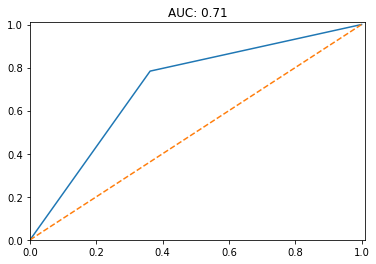

In [86]:
md = RandomForestClassifier(max_depth=15, n_estimators=15, min_samples_leaf=25)
y_prob = train_model(md, X_train, Y_train, X_val)
eval_predictions(Y_val, y_prob, threshold=0.1)

In [ ]:
from sklearn.svm import SVC
svc = SVC()
y_prob = train_model(svc, X_train, Y_train, X_val)
eval_predictions(Y_val, y_prob, threshold=0.1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



### PCA

PCA is sentitive to variance of variables. Therefore, required standardization.

In [10]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_val_st = scaler.transform(X_val)
X_test_st = scaler.transform(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



area under the ROC curve: 0.7837171458358103
              precision    recall  f1-score   support

           0       0.97      0.78      0.86     18009
           1       0.28      0.79      0.42      1991

    accuracy                           0.78     20000
   macro avg       0.63      0.78      0.64     20000
weighted avg       0.90      0.78      0.82     20000

[[14036  3973]
 [  422  1569]]


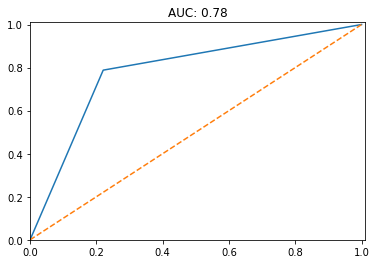

In [45]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(solver = 'lbfgs')
y_prob = train_model(logisticRegr, X_train_st, Y_train, X_val_st)
eval_predictions(Y_val, y_prob, threshold=0.1)

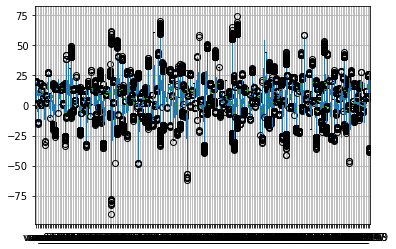

In [31]:
X_train.boxplot()

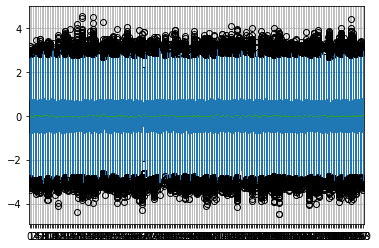

In [33]:
pd.DataFrame(X_train_st).boxplot()

In [11]:
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_st)
X_val_pca = pca.transform(X_test_st)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



area under the ROC curve: 0.4981440023891174
              precision    recall  f1-score   support

           0       0.90      0.66      0.76     18009
           1       0.10      0.34      0.15      1991

    accuracy                           0.63     20000
   macro avg       0.50      0.50      0.46     20000
weighted avg       0.82      0.63      0.70     20000

[[11909  6100]
 [ 1324   667]]


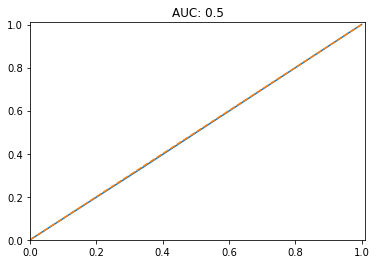

In [14]:
logisticRegr = LogisticRegression(solver = 'lbfgs')
y_prob = train_model(logisticRegr, X_train_pca, Y_train, X_val_pca)
eval_predictions(Y_val, y_prob, threshold=0.1)

### Top N

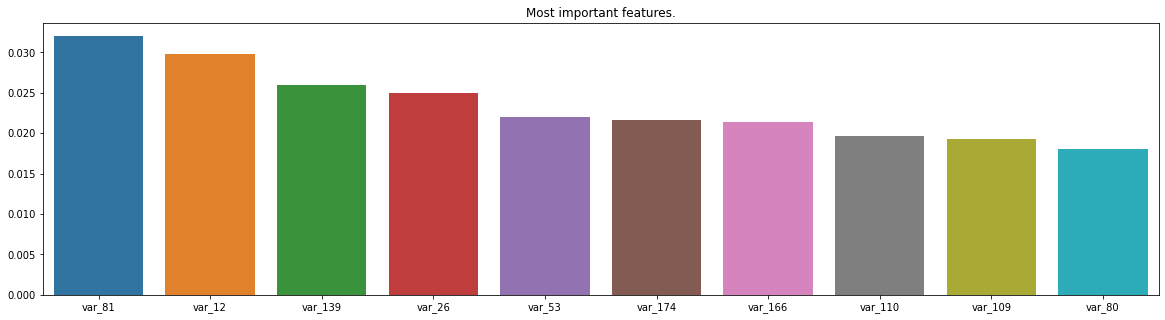

In [15]:
top_features = top_n_features(rfc_grid.best_estimator_, X_train, n=10)

In [16]:
X_train_top = X_train[top_features]
X_val_top = X_val[top_features]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



area under the ROC curve: 0.6267310844828716
              precision    recall  f1-score   support

           0       0.94      0.64      0.76     18009
           1       0.16      0.62      0.25      1991

    accuracy                           0.63     20000
   macro avg       0.55      0.63      0.50     20000
weighted avg       0.86      0.63      0.71     20000

[[11448  6561]
 [  761  1230]]


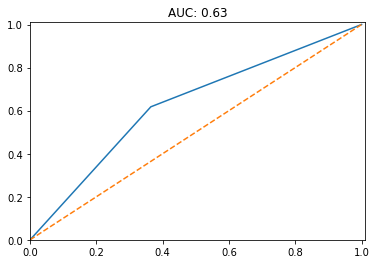

In [18]:
logisticRegr = LogisticRegression(solver = 'lbfgs')
y_prob = train_model(logisticRegr, X_train_top, Y_train, X_val_top)
eval_predictions(Y_val, y_prob, threshold=0.1)

### Variable Clustering

In [20]:
fa = FeatureAgglomeration(n_clusters=32)
X_train_fa = fa.fit_transform(X_train_st)
X_val_fa = fa.transform(X_test_st)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



area under the ROC curve: 0.5004601611243041
              precision    recall  f1-score   support

           0       0.90      0.69      0.78     18009
           1       0.10      0.31      0.15      1991

    accuracy                           0.66     20000
   macro avg       0.50      0.50      0.47     20000
weighted avg       0.82      0.66      0.72     20000

[[12508  5501]
 [ 1381   610]]


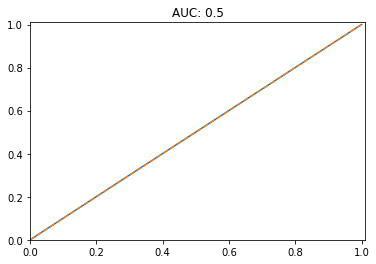

In [21]:
logisticRegr = LogisticRegression(solver = 'lbfgs')
y_prob = train_model(logisticRegr, X_train_fa, Y_train, X_val_fa)
eval_predictions(Y_val, y_prob, threshold=0.1)

### Upsampling

In [27]:
Y_train.target.value_counts()

0    143951
1     16049
Name: target, dtype: int64

In [8]:
from imblearn.over_sampling import ADASYN
# sm = ADASYN(sampling_strategy=0.1, random_state=42)
# X_train_bal, Y_train_bal = sm.fit_sample(X_train, Y_train.ravel())

# Load the over sampled data from drive
df_resampled = pd.read_csv('drive/My Drive/Colab Notebooks/Santander Customer Transaction Prediction/data/resampled_train.csv')
df_resampled = reduce_mem_usage(df_resampled, verbose=True)
X_train_bal = df_resampled.drop(['target'], axis=1)
Y_train_bal = df_resampled['target']
del df_resampled

Memory usage of dataframe is 450.83 MB
Memory usage after optimization is: 112.43 MB
Decreased by 75.1%


In [9]:
pd.DataFrame(Y_train_bal, columns=['target'])['target'].value_counts()

1    150033
0    143951
Name: target, dtype: int64

In [ ]:
# pd.concat([pd.DataFrame(X_train_bal), pd.DataFrame(Y_train_bal, columns=['target'])]).to_csv('resampled_train.csv', index=None)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



area under the ROC curve: 0.6273735307132973
              precision    recall  f1-score   support

           0       0.99      0.28      0.44     18009
           1       0.13      0.97      0.23      1991

    accuracy                           0.35     20000
   macro avg       0.56      0.63      0.33     20000
weighted avg       0.90      0.35      0.42     20000

[[ 5040 12969]
 [   50  1941]]


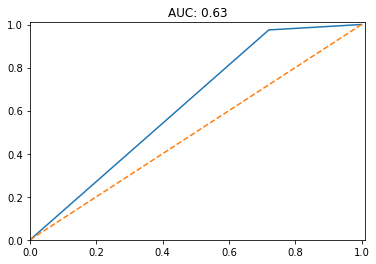

In [26]:
logisticRegr = LogisticRegression(solver = 'lbfgs')
y_prob = train_model(logisticRegr, X_train_bal, Y_train_bal, X_val)
eval_predictions(Y_val, y_prob, threshold=0.1)

area under the ROC curve: 0.500222111166639
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     18009
           1       0.10      1.00      0.18      1991

    accuracy                           0.10     20000
   macro avg       0.55      0.50      0.09     20000
weighted avg       0.91      0.10      0.02     20000

[[    8 18001]
 [    0  1991]]


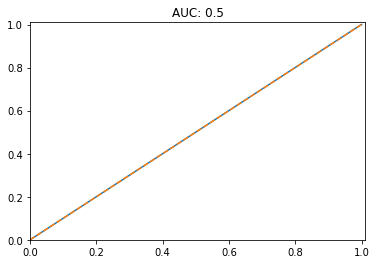

In [27]:
md = RandomForestClassifier(max_depth=15, n_estimators=15, min_samples_leaf=25)
y_prob = train_model(md, X_train_bal, Y_train_bal, X_val)
eval_predictions(Y_val, y_prob, threshold=0.1)